#### Written Franklin (Koquiun) Li Lin 

## Property Lost & Domain Analysis

In this notebook, we will perform some statistical analysis on the merged dataset to see the significance of property lost crimes on the rental price.

#### Import Libraries

In [50]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F  #filtering
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

### Inspect data

In [51]:
# starting a Spark session
spark = (
    SparkSession.builder.appName('Property Lost Further Analysis')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "4g")
    .getOrCreate()
)

pro_lost = spark.read.csv('../data/curated/property_data/property_lost.csv', header=True, inferSchema=True)

# Drop the extra index column (_c0) if it exists
pro_lost = pro_lost.drop('_c0')
pro_lost.show(5)

+----+-----------+------------------+---------------------+--------+-------+-----------------+--------------------+---------------+------------------+--------+
|year|year ending|     police region|local government area|postcode| suburb|location division|       property item|number of items|value of items ($)|sa2_name|
+----+-----------+------------------+---------------------+--------+-------+-----------------+--------------------+---------------+------------------+--------+
|2024|      March|1 North West Metro|              Banyule|    3079|Ivanhoe|    1 Residential|     Car Accessories|             14|            2040.0| Ivanhoe|
|2024|      March|1 North West Metro|              Banyule|    3079|Ivanhoe|    1 Residential|       Cash/Document|             42|           51750.0| Ivanhoe|
|2024|      March|1 North West Metro|              Banyule|    3079|Ivanhoe|    1 Residential|            Clothing|              9|            2140.0| Ivanhoe|
|2024|      March|1 North West Metro|   

In [55]:
aggregated_pro_lost = pro_lost.groupBy("sa2_name").agg(
    F.sum("value of items ($)").alias("total_value_of_items"),
    F.sum("number of items").alias("total_number_of_items"),
    F.count("sa2_name").alias("crime_frequency")
)

# Show the aggregated DataFrame
aggregated_pro_lost.show()

+-----------------+--------------------+---------------------+---------------+
|         sa2_name|total_value_of_items|total_number_of_items|crime_frequency|
+-----------------+--------------------+---------------------+---------------+
|   Brunswick West|          8312812.01|                16450|            622|
|Melbourne Airport|  7681912.5200000005|                 9299|            455|
|         Oak Park|          3126515.84|                 5931|            461|
|          Doveton|          7040118.88|                12222|            991|
|      Pascoe Vale|2.7943650240000006E7|                46915|           1346|
|   Sunshine North|       1.317799632E7|                16593|            684|
|       Ascot Vale|1.1943421559999999E7|                22119|            646|
|           Eltham|  6201149.0600000005|                11095|            643|
|    St Kilda East|   5131574.800000001|                10835|            880|
|          Boronia|          8269985.44|            

In [56]:
aggregated_pro_lost.toPandas().to_csv('../data/curated/property_data/agg_property_lost.csv', index=False)

In [33]:
# Get the number of rows and columns
num_rows = pro_lost.count()
num_columns = len(pro_lost.columns)

print("Shape of the DataFrame:", (num_rows, num_columns))

Shape of the DataFrame: (182268, 11)


In [34]:
year_range = pro_lost.selectExpr("min(year) as min_year", "max(year) as max_year").first()
print("Year range:", year_range.min_year, year_range.max_year)

Year range: 2015 2024


In [35]:
# Get the number of rows and columns
num_rows = pro_lost.count()
num_columns = len(pro_lost.columns)

print("Shape of the DataFrame:", (num_rows, num_columns))

Shape of the DataFrame: (182268, 11)


In [36]:
# read the domain parquet dataset
domain = spark.read.csv('../data/curated/domain_data.csv', header=True, inferSchema=True)
domain.limit(5)

24/10/05 21:09:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , url, price, address, property_type, latitude, longitude, Beds, Baths, Parking, bond, extracted_price, geometry, index_right, sa2_code, sa2_name, chg_flag, chg_lbl, sa3_code, sa3_name, sa4_code, sa4_name, gcc_code, gcc_name, ste_code, ste_name, aus_code, aus_name, areasqkm, loci_uri, geometry_proj
 Schema: _c0, url, price, address, property_type, latitude, longitude, Beds, Baths, Parking, bond, extracted_price, geometry, index_right, sa2_code, sa2_name, chg_flag, chg_lbl, sa3_code, sa3_name, sa4_code, sa4_name, gcc_code, gcc_name, ste_code, ste_name, aus_code, aus_name, areasqkm, loci_uri, geometry_proj
Expected: _c0 but found: 
CSV file: file:///Users/elainezhang/Desktop/project-2-group-real-estate-industry-project-3/data/curated/domain_data.csv
24/10/05 21:09:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , url, price, address, property_type, latitude, longitud

_c0,url,price,address,property_type,latitude,longitude,Beds,Baths,Parking,bond,extracted_price,geometry,index_right,sa2_code,sa2_name,chg_flag,chg_lbl,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,aus_code,aus_name,areasqkm,loci_uri,geometry_proj
0,https://www.domai...,"$1,400.00","10 Allara Court, ...",Townhouse,-37.77427300000001,145.1811258,4.0,3.0,2.0,9125.0,1400.0,POINT (145.181125...,310.0,211021261,Donvale - Park Or...,0,No change,21102,Manningham - East,211,Melbourne - Outer...,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,20.8028,http://linked.dat...,POINT (989259.417...
1,https://www.domai...,$750 per week,"7 Pine Ridge, Don...",House,-37.7912513,145.1756489,4.0,2.0,0.0,3259.0,750.0,POINT (145.175648...,310.0,211021261,Donvale - Park Or...,0,No change,21102,Manningham - East,211,Melbourne - Outer...,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,20.8028,http://linked.dat...,POINT (988607.823...
2,https://www.domai...,$1300 per week,"20 Mulsanne Way, ...",House,-37.7972323,145.1812636,5.0,2.0,2.0,5649.0,1300.0,POINT (145.181263...,310.0,211021261,Donvale - Park Or...,0,No change,21102,Manningham - East,211,Melbourne - Outer...,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,20.8028,http://linked.dat...,POINT (989043.874...
3,https://www.domai...,$825pw / $3585pcm,3 Monterey Cresce...,House,-37.792402,145.1743233,3.0,1.0,5.0,3585.0,825.0,POINT (145.174323...,310.0,211021261,Donvale - Park Or...,0,No change,21102,Manningham - East,211,Melbourne - Outer...,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,20.8028,http://linked.dat...,POINT (988479.463...
4,https://www.domai...,$680.00,3/49 Leslie Stree...,Townhouse,-37.7810117,145.180705,3.0,2.0,2.0,2955.0,680.0,POINT (145.180705...,310.0,211021261,Donvale - Park Or...,0,No change,21102,Manningham - East,211,Melbourne - Outer...,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,20.8028,http://linked.dat...,POINT (989155.458...


In [37]:
# Get the number of rows
num_rows = domain.count()

# Get the number of columns
num_columns = len(domain.columns)

# Print the shape of the DataFrame
print(f"The Domain DataFrame has {num_rows} rows and {num_columns} columns.")

The Domain DataFrame has 9565 rows and 31 columns.


### Further Analysis

In [38]:
# Aggregate property lost data by sa2_name (suburb)
pro_lost_agg = pro_lost.groupBy("sa2_name") \
    .agg(F.avg("number of items").alias("avg_items_lost"),
         F.avg("value of items ($)").alias("avg_value_lost"))

# Join domain data with aggregated property lost data
joined_data = domain.join(pro_lost_agg, 
                          domain.sa2_name == pro_lost_agg.sa2_name,
                          "left_outer")

# Prepare data for regression analysis
data_for_regression = joined_data.select("extracted_price", "avg_items_lost", "avg_value_lost").dropna()

# Create feature vector
assembler = VectorAssembler(inputCols=["avg_items_lost", "avg_value_lost"], outputCol="features")
data_vectorized = assembler.transform(data_for_regression)

# Split data into training and testing sets
train_data, test_data = data_vectorized.randomSplit([0.8, 0.2], seed=42)

# Train linear regression model
lr = LinearRegression(featuresCol="features", labelCol="extracted_price")
model = lr.fit(train_data)

# Make predictions and evaluate the model
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="extracted_price", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

print(f"R-squared: {r2}")
print("Coefficients:")
for feature, coef in zip(["avg_items_lost", "avg_value_lost"], model.coefficients):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept}")

# Calculate correlation between crime rates and property prices
correlation_items = data_for_regression.stat.corr("extracted_price", "avg_items_lost")
correlation_value = data_for_regression.stat.corr("extracted_price", "avg_value_lost")

print(f"Correlation between price and average items lost: {correlation_items}")
print(f"Correlation between price and average value lost: {correlation_value}")

24/10/05 21:09:08 WARN Instrumentation: [71a822c4] regParam is zero, which might cause numerical instability and overfitting.
24/10/05 21:09:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/10/05 21:09:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/10/05 21:09:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


R-squared: 0.04727257955252384
Coefficients:
avg_items_lost: -5.056979893619332
avg_value_lost: 0.00704505113859482
Intercept: 659.9402623250606
Correlation between price and average items lost: -0.08349149312147869
Correlation between price and average value lost: 0.06999344370901639


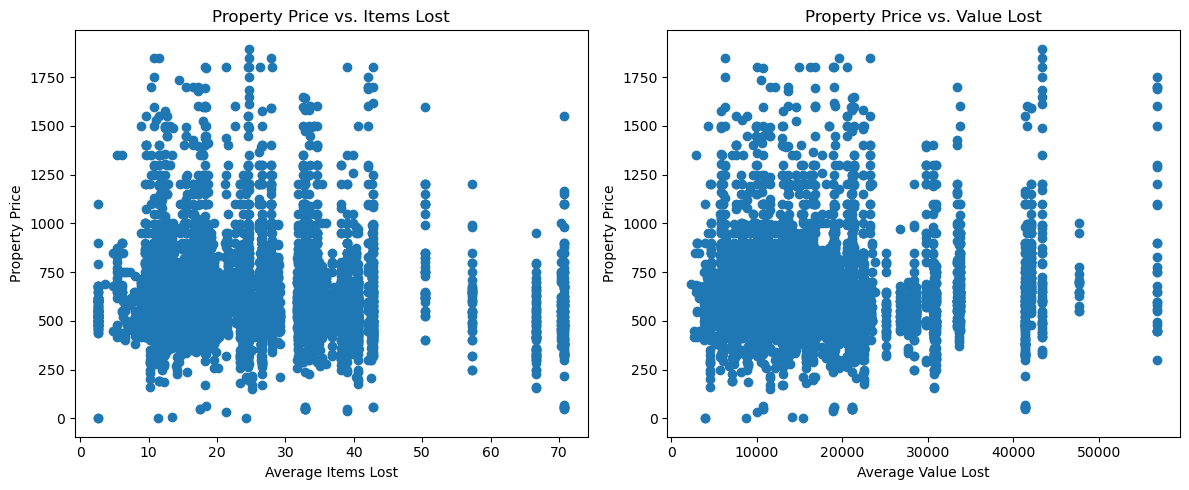

In [39]:
# Visualize the relationship
pd_data = data_for_regression.toPandas()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(pd_data['avg_items_lost'], pd_data['extracted_price'])
plt.xlabel('Average Items Lost')
plt.ylabel('Property Price')
plt.title('Property Price vs. Items Lost')

plt.subplot(1, 2, 2)
plt.scatter(pd_data['avg_value_lost'], pd_data['extracted_price'])
plt.xlabel('Average Value Lost')
plt.ylabel('Property Price')
plt.title('Property Price vs. Value Lost')

plt.tight_layout()
plt.show()

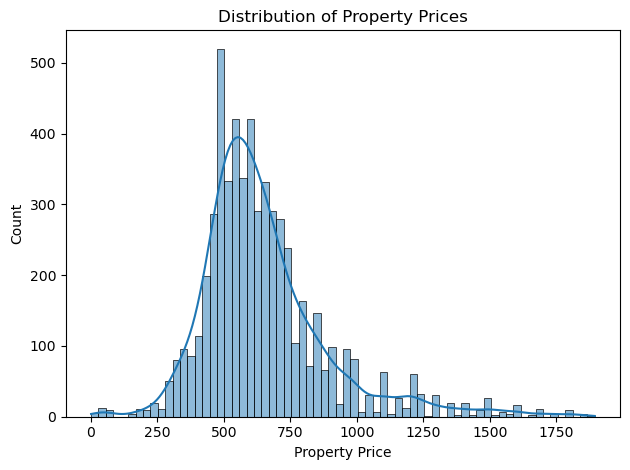

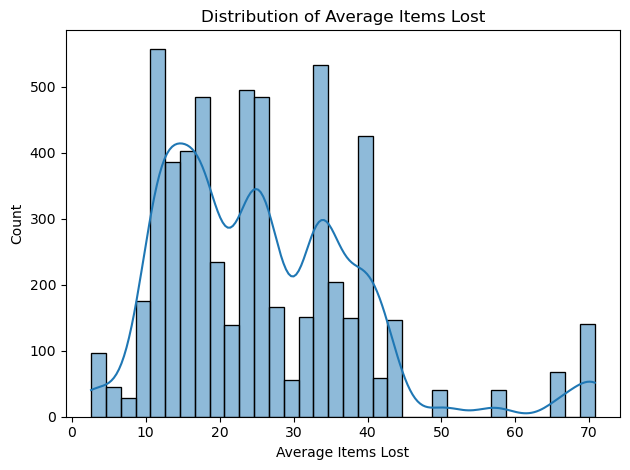

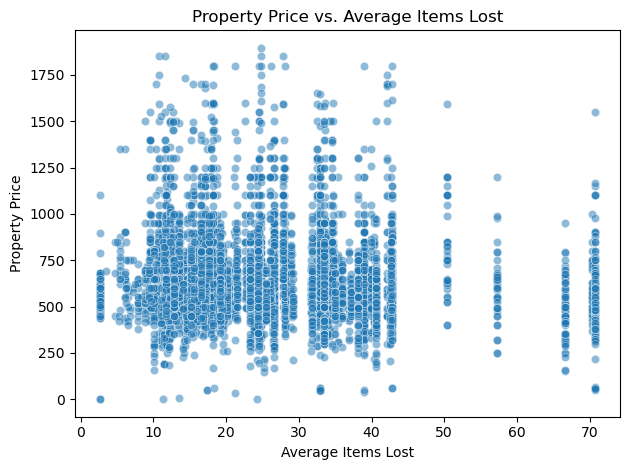

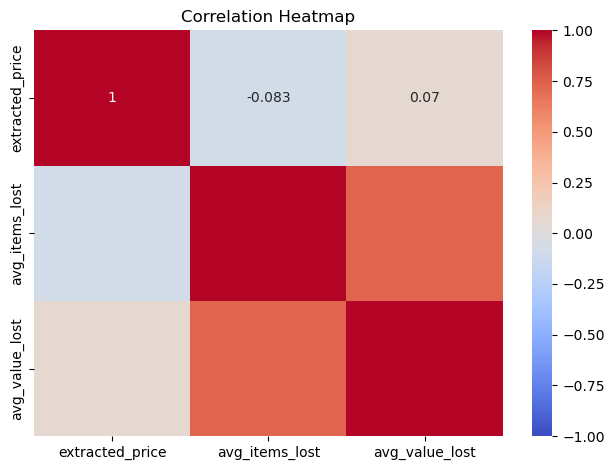

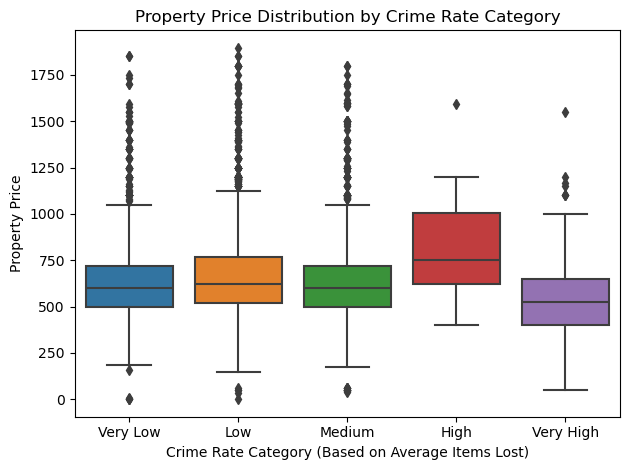

Correlation between avg_items_lost and extracted_price: -0.08349149312147905
Median property price in areas with highest crime rates: 525.0
Median property price in areas with lowest crime rates: 600.0


In [40]:
# Distribution of property prices
#plt.figure(figsize=(12, 6))
sns.histplot(pd_data['extracted_price'], kde=True)
plt.title('Distribution of Property Prices')
plt.xlabel('Property Price')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Distribution of average items lost
#plt.figure(figsize=(12, 6))
sns.histplot(pd_data['avg_items_lost'], kde=True)
plt.title('Distribution of Average Items Lost')
plt.xlabel('Average Items Lost')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Scatter plot of property price vs. average items lost
#plt.figure(figsize=(12, 8))
sns.scatterplot(x='avg_items_lost', y='extracted_price', data=pd_data, alpha=0.5)
plt.title('Property Price vs. Average Items Lost')
plt.xlabel('Average Items Lost')
plt.ylabel('Property Price')
plt.tight_layout()
plt.show()

# Heatmap of correlations
corr_matrix = pd_data[['extracted_price', 'avg_items_lost', 'avg_value_lost']].corr()
#plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Box plot of property prices for different ranges of average items lost
pd_data['items_lost_category'] = pd.cut(pd_data['avg_items_lost'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
#plt.figure(figsize=(14, 8))
sns.boxplot(x='items_lost_category', y='extracted_price', data=pd_data)
plt.title('Property Price Distribution by Crime Rate Category')
plt.xlabel('Crime Rate Category (Based on Average Items Lost)')
plt.ylabel('Property Price')
plt.tight_layout()
plt.show()

# Print additional insights
print("Correlation between avg_items_lost and extracted_price:", 
      pd_data['avg_items_lost'].corr(pd_data['extracted_price']))
print("Median property price in areas with highest crime rates:", 
      pd_data[pd_data['items_lost_category'] == 'Very High']['extracted_price'].median())
print("Median property price in areas with lowest crime rates:", 
      pd_data[pd_data['items_lost_category'] == 'Very Low']['extracted_price'].median())

### Analysis on property lost in SA2 districts

In [41]:
# Pearson correlation (linear relationship)
pearson_corr = pd_data['avg_items_lost'].corr(pd_data['extracted_price'])

# Spearman correlation (non-linear relationships)
spearman_corr = pd_data['avg_items_lost'].corr(pd_data['extracted_price'], method='spearman')

print("Pearson Correlation:", pearson_corr)
print("Spearman Correlation:", spearman_corr)

Pearson Correlation: -0.08349149312147905
Spearman Correlation: -0.07238306620111944


In [42]:
# Check for missing values in 'avg_items_lost' and 'extracted_price'
missing_values = pd_data[['avg_items_lost', 'extracted_price']].isnull().sum()

# Check for infinity values in 'avg_items_lost' and 'extracted_price'
infinity_values = pd_data[['avg_items_lost', 'extracted_price']].applymap(np.isinf).sum()

print("Missing values:\n", missing_values)
print("Infinity values:\n", infinity_values)


Missing values:
 avg_items_lost     0
extracted_price    0
dtype: int64
Infinity values:
 avg_items_lost     0
extracted_price    0
dtype: int64


In [43]:
# Perform a left join on 'sa2_name'
merged_df = pro_lost.join(domain, on='sa2_name', how='left')

In [44]:
# Convert PySpark DataFrame to Pandas
pandas_df = merged_df.select("value of items ($)", "extracted_price").toPandas()

# Check the first few rows
print(pandas_df.head())

   value of items ($)  extracted_price
0              2040.0           1150.0
1              2040.0            880.0
2              2040.0            850.0
3              2040.0            720.0
4              2040.0            550.0


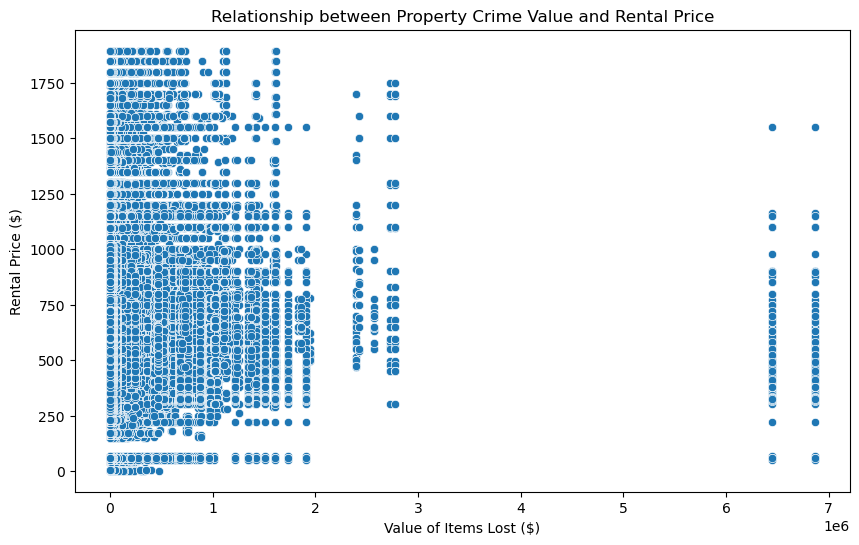

In [45]:
# Create a scatter plot using Pandas DataFrame
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pandas_df['value of items ($)'], y=pandas_df['extracted_price'])
plt.title('Relationship between Property Crime Value and Rental Price')
plt.xlabel('Value of Items Lost ($)')
plt.ylabel('Rental Price ($)')
plt.show()

In [46]:
# Calculate crime frequency as the number of items lost per SA2 region
crime_grouped_df = pro_lost.groupBy('sa2_name').agg(
    {'number of items': 'sum', 'value of items ($)': 'sum', 'sa2_name': 'count'}
).withColumnRenamed('sum(number of items)', 'total_items_lost') \
 .withColumnRenamed('sum(value of items ($))', 'total_value_lost') \
 .withColumnRenamed('count(sa2_name)', 'crime_frequency')

crime_grouped_df.show()

+-----------------+---------------+--------------------+----------------+
|         sa2_name|crime_frequency|    total_value_lost|total_items_lost|
+-----------------+---------------+--------------------+----------------+
|   Brunswick West|            622|          8312812.01|           16450|
|Melbourne Airport|            455|  7681912.5200000005|            9299|
|         Oak Park|            461|          3126515.84|            5931|
|          Doveton|            991|          7040118.88|           12222|
|      Pascoe Vale|           1346|2.7943650240000006E7|           46915|
|   Sunshine North|            684|       1.317799632E7|           16593|
|       Ascot Vale|            646|1.1943421559999999E7|           22119|
|           Eltham|            643|  6201149.0600000005|           11095|
|    St Kilda East|            880|   5131574.800000001|           10835|
|          Boronia|            680|          8269985.44|           21560|
|      Templestowe|            542|   

In [47]:
# Group the rental data by SA2 region to calculate the average rental price
rental_grouped_df = domain.groupBy('sa2_name').agg(
    {'extracted_price': 'avg'}
).withColumnRenamed('avg(extracted_price)', 'average_rental_price')

rental_grouped_df.show()

+--------------------+--------------------+
|            sa2_name|average_rental_price|
+--------------------+--------------------+
|      Brunswick West|               554.0|
|Hoppers Crossing ...|    448.780487804878|
|     South Melbourne|   903.3333333333334|
|Knoxfield - Scoresby|   661.6666666666666|
|   Caulfield - North|    686.109756097561|
|        Lalor - West|   559.5833333333334|
|Truganina - South...|   541.4473684210526|
|Bentleigh East - ...|   873.2258064516129|
|Reservoir - South...|             550.875|
|            Oak Park|   595.6666666666666|
|             Doveton|   512.8571428571429|
|         Pascoe Vale|   573.6571428571428|
|      Epping - South|            511.5625|
|       Coburg - East|   591.1428571428571|
|       Coburg - West|   696.6666666666666|
|  Chelsea - Bonbeach|   620.1428571428571|
|       St Kilda East|   710.5376344086021|
|          Ascot Vale|   677.3611111111111|
|              Eltham|   629.5833333333334|
|      Sunshine North|   554.615

In [48]:
# Merge the crime frequency data with the rental price data
merged_grouped_df = crime_grouped_df.join(rental_grouped_df, on='sa2_name', how='inner')

# Show the merged data
merged_grouped_df.show()

+----------------+---------------+--------------------+----------------+--------------------+
|        sa2_name|crime_frequency|    total_value_lost|total_items_lost|average_rental_price|
+----------------+---------------+--------------------+----------------+--------------------+
|  Brunswick West|            622|          8312812.01|           16450|               554.0|
|        Oak Park|            461|          3126515.84|            5931|   595.6666666666666|
|         Doveton|            991|          7040118.88|           12222|   512.8571428571429|
|     Pascoe Vale|           1346|2.7943650240000006E7|           46915|   573.6571428571428|
|  Sunshine North|            684|       1.317799632E7|           16593|   554.6153846153846|
|      Ascot Vale|            646|1.1943421559999999E7|           22119|   677.3611111111111|
|          Eltham|            643|  6201149.0600000005|           11095|   629.5833333333334|
|   St Kilda East|            880|   5131574.800000001|     

In [49]:
# Prepare features for linear regression
assembler = VectorAssembler(inputCols=['total_value_lost', 'total_items_lost', 'crime_frequency'], outputCol='features')
assembled_df = assembler.transform(merged_grouped_df)

# Fit linear regression model
lr = LinearRegression(featuresCol='features', labelCol='average_rental_price')
lr_model = lr.fit(assembled_df)

# Print regression results
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

24/10/05 21:09:31 WARN Instrumentation: [4e3cc4e0] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [7.681288055923722e-06,-0.005482815688450505,0.011301251690373604]
Intercept: 648.2550903385555


Total number of crimes (items lost) negatively affects rental prices, suggesting that more crimes make areas less attractive to live in.
Crime frequency, however, shows a slight positive relationship, which might indicate that frequent but minor crimes in otherwise desirable locations do not significantly deter renters.